# **Variational Quantum Eigensolver**
***
Variational Quantum Eigensolver is one of the most promising quantum algorithm in current research. As the name suggests, the goal of the algorithm is to find the eigenvalue(s) of some matrix, representing the Hamiltonian of some system.  The strength of the VQE Algorithm, and the reason it has gained so much popularity so quickly, is the flexibility of the algorithm, allowing for a wide range of solvable problems.

In order to make sure that all cells of code run properly throughout this lesson, please run the following cell of code below:
 

In [1]:
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit, Aer, execute
import numpy as np
import math as m
import scipy as sci
import random
import matplotlib
import matplotlib.pyplot as plt
from itertools import permutations
import warnings
warnings.filterwarnings('ignore')
S_simulator = Aer.backends(name='statevector_simulator')[0]
M_simulator = Aer.backends(name='qasm_simulator')[0]

# **The VQE Workflow**
***

An important idea to understand about the VQE Algorithm is that it is fundamentally a hybrid algorithm. This means that in order to be successful, it requires synergy between the classical and quantum components. The figure below shows a rough outline of the roles each computer plays, as well as the information obtained through each and fed into the other for further processing

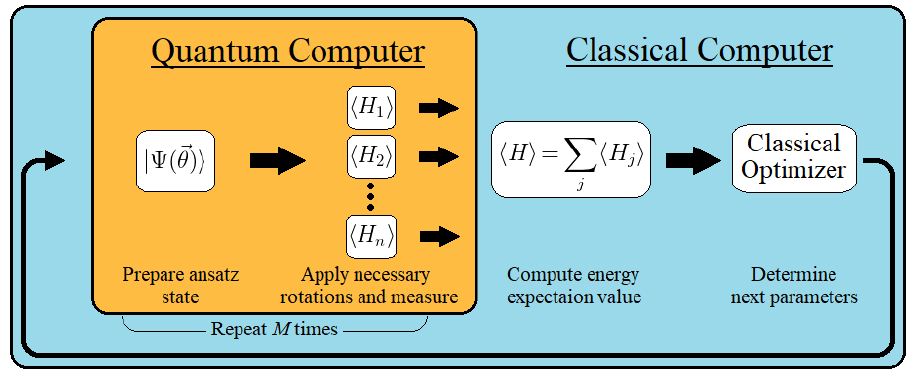

Shown above is the workflow for the VQE Algorithm. As illustrated by the boxes, the quantum component of our algorithm is best classified as a subroutine for the overarching classical component.

# **The Variational Principle**
***

The core idea behind the VQE Algorithm comes from the Variational Principle, from which the "V" in our algorithm gets its name from. Simply put, the Variational Principle states that there is a single quantum state for which our system will yield the lowest possible expectation value: $|\psi_{min}⟩$

$$ E_{min} = \langle \psi_{min} |H|\psi_{min}⟩  $$
where H is the Hamiltonian of the system.

If we prepare any other quantum state:$|Ψ(θ)⟩$, then we are guaranteed that the resulting energy expectation value will be higher than $E_{min}$.

$$ E_{min} \leq E(θ) \langle Ψ(θ) |H| Ψ(θ)⟩  $$

VQE is based around searching for the optimal state $|\psi_{min}⟩$ amongst all possible $|Ψ(θ)⟩$ states commonly referred to as the ansatz states:

$$solution: |Ψ(θ)⟩ = |\psi_{min}⟩ $$ 

Searching through the parameter space θ comes with its own set of challenges. For starters, how do we know when we've found $|\psi_{min}⟩$? Suppose we are using VQE to solve a problem for which the ground state energy is unknown, how can we be certain that the best $|Ψ(θ)⟩$  we find is truly $|\psi_{min}⟩$. Unfortunately, our algorithm can't tell us that, which means that the smallest energy expectation value we find is simply the best approximation our algorithm can provide. However, positive aspect is that every solution we find which yield a lower energy provides us with a new upper bound on the ground state energy for the given Hamiltonian. **Thus, after running VQE, the best solution we find could be the ground state, but at the very least we can say that the true ground state energy of the system cannot be larger than our best $|Ψ(θ)⟩$. In turn, providing such information back to a classical computer could immensely help narrow down the search, ultimately leading to a completion of the problem which would have been otherwise impossible for a classical computer alone**.
 

## **Single Qubit Ansatz States**

Having just covered recall how our VQE Algorithm will be driven by the Variational Principle, let's look at how to create ansatz states in more detail. Here our solution is dependent of finding $|\psi_{min}⟩$, which in principle could be anywhere within an N-qubit Hilbert space, where N is the number of qubits in our system, so we must consider all possible $|Ψ(θ)\rangle$ states.


As our first example, we will consider the case of a single qubit, and the quantum circuit necessary for spanning the complete 1-qubit Hilbert Space. If we want to consider all possible quantum states that a single qubit can occupy, we needn't look any further than the Bloch Sphere:

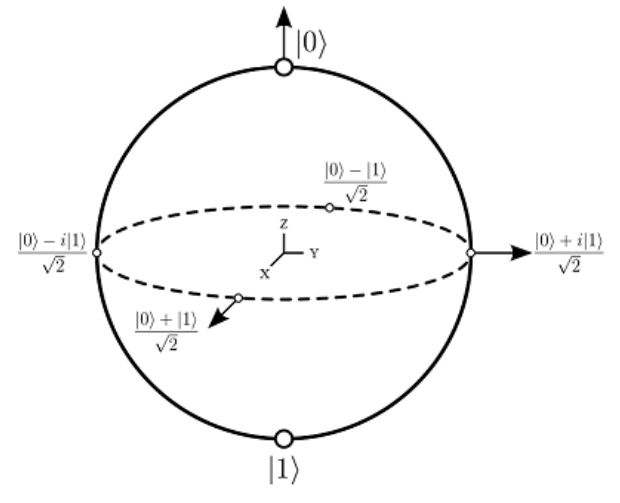

As shown above, the Bloch sphere is a great visual representation of the space given of a single qubit. Specifically, the surface of the Bloch Sphere represents all possible $|Ψ(θ)\rangle$ states we need for our ansartz. The question then becomes, given some arbitrary location on the surface of the Bloch Sphere , how do we create the corresponding quantum state?


The nice thing about the space of all possible single qubit states, and the reason why the Bloch Sphere representation is so great, is that the answer to our question comes from a simple geometric answer: any position along the surface of a sphere can be specified using two coordinates. More specifically, starting from the $|0⟩$, we can transform to any possible state using two rotation operators:

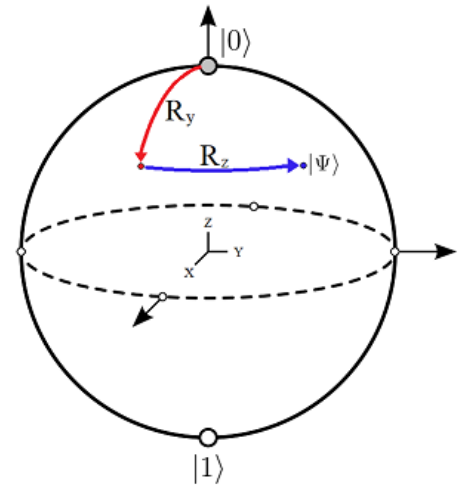

The figure above shows how one can use thw $R_y$ and $R_z$ gates to transform our initial |0⟩ state to anywhere along the surface of the Bloch Sphere.  For completeness, below is an outline of the combination of these two operators
in succession: 

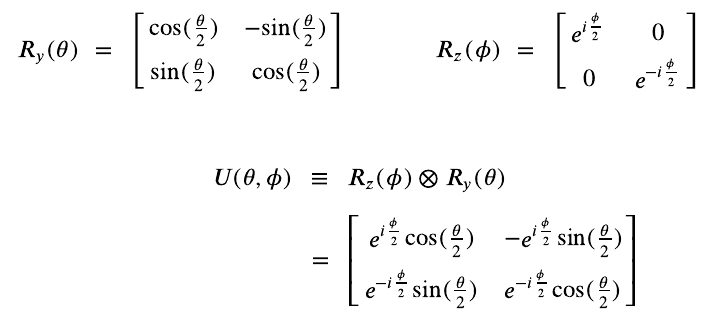

With this operation, we can create the full space of single-qubit ansatz states:

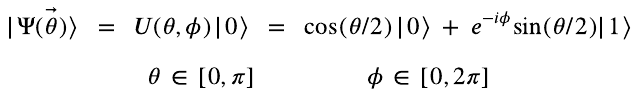

In [2]:
def Single_Qubit_Ansatz( qc, qubit, params ):
  qc.ry( params[0], qubit )
  qc.rz( params[1], qubit )
#================================================
q = QuantumRegister( 1, name='q' )
qc= QuantumCircuit( q, name='qc' )
theta = m.pi/3
phi = 3*m.pi/2

job =   execute(qc, S_simulator)
result =  job.result()
result.get_statevector()



Statevector([1.+0.j, 0.+0.j],
            dims=(2,))


In [3]:
Single_Qubit_Ansatz( qc, q[0], [theta,phi] )

job =   execute(qc, S_simulator)
result =  job.result()
result.get_statevector()

Statevector([-0.61237244-0.61237244j, -0.35355339+0.35355339j],
            dims=(2,))


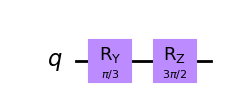

In [4]:
qc.draw('mpl')

# **Hamiltonian Decomposition and the Measurement Basis**
***

With our ansatz state operator now in hand, the next topic for our VQE Algorithm is how to measure expectation values. As a reminder, the quantity of interest
for which we are searching for is the energy expectation value, shown below:

$$E(θ) = ⟨Ψ(θ)|H|Ψ(θ)⟩$$

We use repeated measurements to determine expectation values.  Simply put, if we are working with a real quantum computer, then the only means of computing the expectation value of a quantum state is to prepare and measure the state many times. Through this repetition we can build up the approximate probabilities of each
individual state, and then multiply each state's weight with its associated energy contribution.

To begin our discussion, let's consider a single qubit system whose Hamiltonian is as follows:

$$H = X + Z$$

Not particularly exciting, but there is a lot to learn from this simple Hamiltonian. For starters, let's consider what our energy expectation value for this system
will look like:

$$E( θ ) = ⟨Ψ( θ)|X + Z|Ψ( θ )⟩$$
$$E( θ ) = ⟨Ψ( θ)|X|Ψ(θ )⟩ + ⟨Ψ( θ )|Z|Ψ(θ )⟩$$
$$E( θ ) = E_X ( θ ) + E_Z ( θ)$$

As shown above, when we have a Hamiltonian that can be expressed as a linear combination of terms, the total energy expectation value is equal to the sum
of the individual expectation values. **For our VQE Algorithm this is very important, as it means that we can study arbitrarily long Hamiltonians so long as we can decompose them linearly**. However, there is a limitation to the kinds of Hamiltonians we can study with VQE, namely the operator which compose them. Plugging the eigenvalues and eigestates into our equation for
 E( θ ) , we can write out the full expression for the energy expectation value of our Hamiltonian:

 $$E( θ ) = (+1)|⟨+|Ψ(θ)⟩|^{2} + (−1)|⟨−|Ψ(θ)⟩|^{2} + (+1)|⟨0|Ψ(θ)⟩|^{2} + (−1)|⟨1|Ψ(θ)⟩|^{2}$$


Because we can seperate our problem into the two quantities $E_X(θ)$ and $E_Z(θ)$, we can think of each of them as their own seperate problem, each requiring the preparation and measurement process just described. For the two quantities stemming from the Z component of our Hamiltonian, determining the probabilities for |0⟩ and |1⟩ are straightforward, but how about the other two? **If asked to compute the quantity $|⟨−|Ψ(θ)⟩|^{2}$ for example, how would we go about it on a real quantum computer (no looking at the wavefunction!)? To emphasize why this is a problem, remember that we are always bound to a measurement at the end of the day, but more specifically a measurement in the computational basis  { |0⟩,|1⟩}**.


Determining expectation values which depend on eigenstates other than |0⟩ or |1⟩ is problematic because we lose critical piece of information in phases when we measure, it prevents us from being able to reconstruct the true underlying wavefunction. However, fear not, as there is yet another way we can compute our quantity of interest, namely the overlap of the $|+⟩$ state with our ansatz state. To do this, we will clearly apply an additional gate just prior to the measurement, essentially transforming our measurement results from the computational basis to that of the eigenstate of our Hamiltonian. For the case of our Hamiltonian H = X, the required transformation is best visualized once again using the Bloch Sphere:

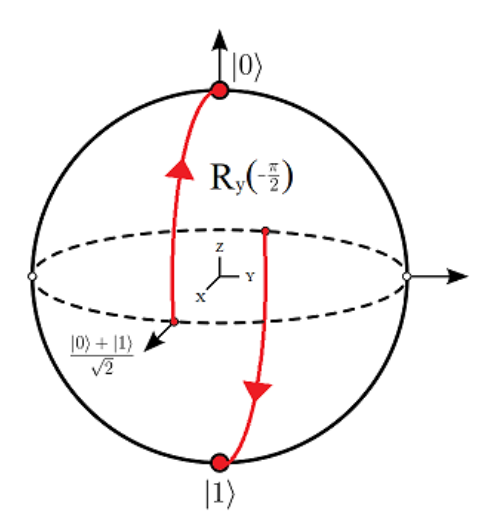

To compliment what the diagram above is illustrating, the
 $R_y$ (−π/2 ) rotation gate transforms between the two sets of states: { |0⟩,|1⟩} and { |+⟩,|−⟩ } .

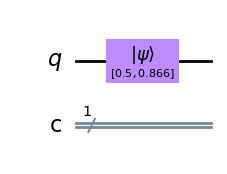

In [5]:
Shots = 10000
#============================================
q = QuantumRegister(1,name='q')
c = ClassicalRegister(1,name='c')
qc= QuantumCircuit(q,c,name='qc')

qc.initialize( [m.sqrt(1/4),m.sqrt(3/4)], q)
qc.draw('mpl')

In [6]:
job =   execute(qc, S_simulator)
result =  job.result()
result.get_statevector()

Statevector([0.5      +0.j, 0.8660254+0.j],
            dims=(2,))


In [7]:
qc.measure(q,c)

job = execute(qc,M_simulator,shots=10000)
result = job.result()
M1 = result.get_counts(qc)

print( '\n{ |0> , |1> } Basis - Energy Expectation Value:',round( (M1['0']/Shots)+(-1.0*M1['1']/Shots) ,3) )


{ |0> , |1> } Basis - Energy Expectation Value: -0.498


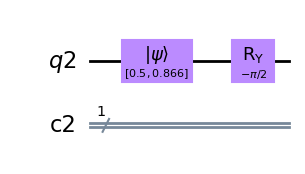

In [8]:
q2 = QuantumRegister(1,name='q2')
c2 = ClassicalRegister(1,name='c2')
qc2 = QuantumCircuit(q2,c2,name='qc2')


qc2.initialize( [m.sqrt(1/4),m.sqrt(3/4)], q2)

qc2.ry( -m.pi/2, q2[0] )
qc2.draw('mpl')

In [9]:
qc2.measure(q2,c2)

job = execute(qc2,M_simulator,shots=10000)
result = job.result()
M2 = result.get_counts(qc2)

print( '\n{ |+> , |-> } Basis - Energy Expectation Value:',round( (M2['0']/Shots)+(-1.0*M2['1']/Shots) ,3) )


{ |+> , |-> } Basis - Energy Expectation Value: 0.853


Additionally, this process of changing bases works for higher dimensional systems as well, so long as each qubit receives the proper rotation just prior to the
final measurement. In fact, each qubit can receive a different rotation based on the Hamiltonian, for example:

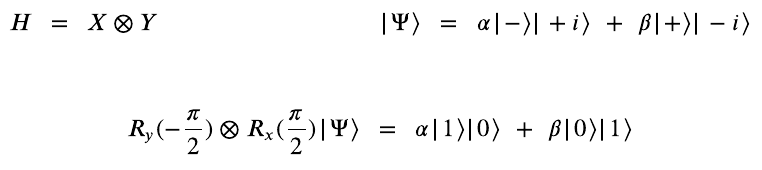

In the example above we've used the shorthand notation for the Y operator's eigenstates: | ± i⟩. To emphasize what this example is demonstrating, so long as we have a Hamiltonian that is composed of Pauli operations on each qubit, we can compute the total energy expectation value by applying the necessary
rotations on each qubit just prior to the measurement. These rotations correspond to each qubit's particular Pauli Operator in the Hamiltonian, and are given below:

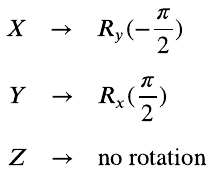

## **Classical Optimizer**
***
Essentially, the role of the classical computer is to determine which $|Ψ(θ)\rangle$ states to feed the quantum computer.  But in order to find our ground state solution as quickly as possible, this process for determining the best ansatz state needs to be optimal. Buried within our hybrid quantum/classical eigen solving algorithm is a classical optimization technique. And this classical
optimizer can really be thought of as the engine of the algorithm, largely responsible for how quickly the algorithm can converge on the correct solution. In principle, the best suited classical optimization technique will vary from problem to problem, which means we need to tap into the wealth of already known
optimizers.



# **Single Qubit VQE Example**
***

The time has come to put all of our VQE pieces together and construct our first working example. We will start by defining the Hamiltonian for which we are
seeking to find the ground state energy of:

$$H = 3X − 2Y + Z$$

As shown above, our Hamiltonian consists of all three Pauli Operators, as well as different weighing contributions from each. These weights don't actually affect the quantum components of the algorithm in any way, as we simply pass them along to our classical computer when we compute the total expectation value. For this first example, we will not be implementing any classical optimizer, but rather span the complete $θ$ parameter space.

In [10]:
def Heatmap(data, show_text, show_ticks, ax, cmap, cbarlabel, **kwargs):
  '''
  Input:
  data (array)
  show_text (Bool)
  show_ticks (Bool)
  ax (Matplotlib subplot)
  cmap (string)
  Takes in data and creates a 2D Heatmap
  '''
  valfmt="{x:.1f}"
  textcolors=["black", "white"]
  threshold=None
  cbar_kw={}
  #----------------------------
  if not ax:
    ax = plt.gca()
  im = ax.imshow(data, cmap=cmap, **kwargs)
  cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
  cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")
  ax.grid(which="minor", color="black", linestyle='-', linewidth=1)
  if( show_ticks == True ):
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    ax.tick_params(which="minor", bottom=False, left=False)
  if threshold is not None:
    threshold = im.norm(threshold)
  else:
    threshold = im.norm(data.max())/2.
  kw = dict(horizontalalignment="center", verticalalignment="center")
  if isinstance(valfmt, str):
    valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)
  if( show_text == True ):
    for i in range(data.shape[0]):
      for j in range(data.shape[1]):
        kw.update(color=textcolors[int(im.norm(data[i, j]) < threshold)])
        text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)

Ground State Energy:  -3.624 θ =  1.466 φ =  2.51327


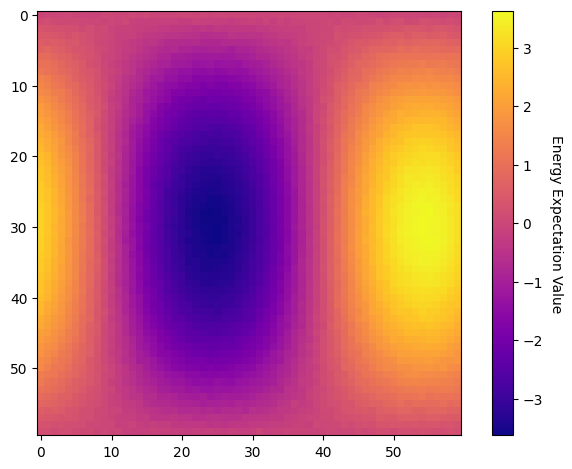

In [11]:
t1 = 60
t2 = 60
Shots = 10000
Parameter_Space = np.zeros(shape=(t1,t2))
Ground_State = [100,0,0]
H = {'X':3,'Y':-2,'Z':1}
Hk = list( H.keys() )
#--------------------------------------------------
for i in np.arange( t1 ):
  theta = m.pi*(i/t1)
  for j in np.arange( t2 ):
    phi = 2*m.pi*(j/t2)
    Measures = []
    for k in np.arange(len(Hk)):
      q = QuantumRegister( 1, name='q' )
      c = ClassicalRegister( 1, name='c' )
      qc= QuantumCircuit( q, c, name='qc')
      Single_Qubit_Ansatz( qc, q[0], [theta, phi] )
      if( Hk[k] == 'X' ):
        qc.ry( -m.pi/2, q[0])
      if( Hk[k] == 'Y' ):
        qc.rx(m.pi/2, q[0])
      qc.measure( q,c )
      M = {'0':0,'1':0}
      job = execute(qc,M_simulator,shots=10000)
      result = job.result()
      M.update(result.get_counts(qc))
      Measures.append( M )
    Parameter_Space[i,j] = H['X']*(Measures[0]['0'] - Measures[0]['1'])/Shots + H['Y']*(Measures[1]['0'] - Measures[1]['1'])/Shots
    if( Parameter_Space[i,j] < Ground_State[0] ):
      Ground_State[0] = Parameter_Space[i,j]
      Ground_State[1] = theta
      Ground_State[2] = phi

#==================================================
print('Ground State Energy: ',round(Ground_State[0],5),'\u03B8 = ',round(Ground_State[1],3),'\u03C6 = ',round(Ground_State[2],5))
fig, ax = plt.subplots()
show_text = False
show_ticks = False
Heatmap(Parameter_Space, show_text, show_ticks, ax, "plasma", "Energy Expectation Value")
fig.tight_layout()
plt.show()

The energy landscape shown above represents all of the possible ansatz states we can create with the parameters θ and φ , spanning the complete surface of the Bloch Sphere. Each combination of parameters creates a unique ansatz state, yielding the various energy expectation values shown above. Going forward, the next step in our algorithm is to use this parameter space as a guide for finding the ground state energy, corresponding to the center of the dark blue region. To do this, we will call upon the well known technique used in the optimization: Gradient Descent, to iteratively find our way into the global minima of this parameter space.

## Should Gradient Descent be our first choice?

In [12]:
def VQE_Gradient_Descent(qc, q, H, Ansatz, theta, phi, epsilon, step, **kwargs):
  '''
  Input:
  qc (QuantumCircuit)
  q (QuantumRegister)
  H (Dictionary)
  Ansatz (Single_Qubit_Ansatz function)
  theta (float)
  phi (float)
  epsilon (float)
  step (float)
  Keyword Arguments:
  measure (Bool) - Dictates whether to use measurements or the wavefunction
  shots (integer) - Dictates the number of measurements to use per computation
  Computes and returns the next values for beta and gamma using gradient descent, for a single qubit VQE
  '''
  EV_type = 'measure'
  if 'measure' in kwargs:
    M_bool = kwargs['measure']
    if( M_bool == True ):
      EV_type = 'measure'
    else:
      EV_type = 'wavefunction'
  Shots = 1000
  if 'shots' in kwargs:
    Shots = kwargs['shots']
  params = [theta,phi]
  ep_params = [[theta+epsilon,phi],[theta-epsilon,phi],[theta,phi+epsilon],[theta,phi-epsilon]]
  Hk = list( H.keys() )
  EV = []
  for p4 in np.arange( len( ep_params ) ):
    H_EV = 0
    qc_params = ep_params[p4]
    for h in np.arange( len(Hk) ):
      qc_params = ep_params[p4]
      q = QuantumRegister(1)
      c = ClassicalRegister(1)
      qc= QuantumCircuit(q,c)
      Ansatz( qc, q[0], [qc_params[0], qc_params[1]] )
      if( Hk[h] == 'X' ):
        qc.ry(-m.pi/2,q[0])
      if( Hk[h] == 'Y' ):
        qc.rx(-m.pi/2,q[0])
      if( EV_type == 'wavefunction' ):
        sv = execute( qc, S_simulator, shots=1 ).result().get_statevector()
        H_EV = H_EV + H[Hk[h]]*( (np.conj(sv[0])*sv[0]).real - (np.conj(sv[1])*sv[1]).real )
      elif( EV_type == 'measure' ):
        qc.measure( q,c )
        M = {'0':0,'1':0}
        job = execute(qc,M_simulator,shots=1000)
        result = job.result()
        M.update(result.get_counts(qc))
        
        # M.update( Measurement( qc, shots=Shots, print_M=False, return_M=True ) )
        H_EV = H_EV + H[Hk[h]]*(M['0']-M['1'])/Shots
    EV.append(H_EV)
  theta_slope = ( EV[0]-EV[1] )/(2.0*epsilon)
  phi_slope =( EV[2]-EV[3] )/(2.0*epsilon)
  next_theta = theta - theta_slope*step
  next_phi = phi - phi_slope*step
  return next_theta,next_phi

The cell of code below uses a function called VQE_Gradient_Descent, which handles all of the computations neccessary for computing the slope at each location, and providing the next set of θ and φ values for the ansatz state. The code starts off with a randomly chosen pair of θ and φ values, and the goal is to hopefully find our way to the oprtimal set of values shown above, corresponding to the ground state energy:
 

In [13]:
H = {'X':3,'Y':-2,'Z':1}
Hk = list( H.keys() )
Shots = 100000
Ground_State = [100,0,0]
epsilon = 0.001
step_size = 0.01
delta = 0.0001
M_bool = True

#-----------------------

EV = 100
EV_old = 1000
terminate = False

#========================================================

theta = m.pi*random.random()
phi = 2*m.pi*random.random()
iters = 0
while( (abs( EV - EV_old ) > delta) and (terminate==False) ):
  EV_old = EV
  EV = 0
  for k in np.arange(len(Hk)):
    q = QuantumRegister( 1, name='q' )
    c = ClassicalRegister( 1, name='c' )
    qc= QuantumCircuit( q, c, name='qc')
    Single_Qubit_Ansatz( qc, q[0], [theta, phi] )
    if( Hk[k] == 'X' ):
      qc.ry(-m.pi/2, q[0])
    if( Hk[k] == 'Y' ):
      qc.rx(m.pi/2, q[0])
    qc.measure( q,c )
    M = {'0':0,'1':0}
    job = execute(qc,M_simulator,shots=100000)
    result = job.result()
    M.update(result.get_counts(qc))
    
    EV = EV + H[Hk[k]]*(M['0']-M['1'])/Shots
  print('Iterations: ',iters,'EV:',round(EV,5),'\u03B8 = ',round(theta,5),'\u03C6 = ',round(phi,5))
  if( EV > EV_old):
    terminate = True
  else:
    if( EV < Ground_State[0] ):
      Ground_State[0] = EV
      Ground_State[1] = theta
      Ground_State[2] = phi
    theta_old = theta
    phi_old = phi
    theta,phi = VQE_Gradient_Descent(qc,q,H,Single_Qubit_Ansatz,theta,phi,epsilon,step_size,measure=M_bool,shots=100000)
    iters = iters + 1
if( (abs( EV - EV_old ) < delta) or (terminate==True) ):
  print('\n_____ Gradient Descent Complete _____\n')
  print('Iterations: ',iters,'EV:',round(Ground_State[0],5),'\u03B8 = ',round(Ground_State[1],5),'\u03C6 = ',round(Ground_State[2],5))

Iterations:  0 EV: -0.60832 θ =  0.58741 φ =  3.31792
Iterations:  1 EV: -0.57366 θ =  0.57601 φ =  3.31982

_____ Gradient Descent Complete _____

Iterations:  1 EV: -0.60832 θ =  0.58741 φ =  3.31792


Run the cell of code above several times, and you are likely to find that in most cases the algorithm never makes it past 5 iterations, and yields a final energy
which is clearly quite far off from true ground state energy. So we must ask, why is this happening? 

The root of problem demonstrated above turns out to have nothing to do with the Gradient Descent technique (which I can assure you we implemented
correctly in our code), but rather with the information we are feeding the optimizer. More specifically, in the previous lesson we traversed expectation value
landscapes which were computed using wavefunctions, while here we are doing everything strictly through measurements. Consequently, the values which
we are providing the Gradient Descent optimizer are approximations subject to small fluxuations, which in turn are causing the technique to fail. To
demonstrate this, the two cells of code below produce the same subsection of the energy landscape plot from earlier, but do so by calculating the expectation
values two different ways:

## **Method 1: Approximating ⟨H⟩ Using Measurements**

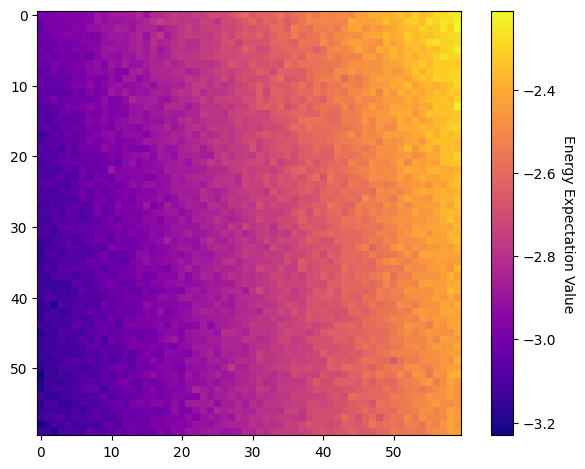

In [14]:
t1 = 60
t2 = 60
Shots = 10000
Parameter_Space = np.zeros(shape=(t1,t2))
Ground_State = [100,0,0]
H = {'X':3,'Y':-2,'Z':1}
Hk = list( H.keys() )
#--------------------------------------------------
for i in np.arange( t1 ):
  theta = m.pi/2+ (m.pi/10)*(i/t1)
  for j in np.arange( t2 ):
    phi = m.pi+ (m.pi/10)*(j/t2)
    EV = 0
    for k in np.arange(len(Hk)):
      q = QuantumRegister( 1, name='q' )
      c = ClassicalRegister( 1, name='c' )
      qc= QuantumCircuit( q, c, name='qc')
      Single_Qubit_Ansatz( qc, q[0], [theta, phi] )
      if( Hk[k] == 'X' ):
        qc.ry(-m.pi/2, q[0])
      if( Hk[k] == 'Y' ):
        qc.rx(m.pi/2, q[0])
      qc.measure( q,c )
      M = {'0':0,'1':0}
      job = execute(qc,M_simulator,shots=10000)
      result = job.result()
      M.update(result.get_counts(qc))
      EV = EV + H[Hk[k]]*(M['0']-M['1'])/Shots
    Parameter_Space[i,j] = EV
    if( Parameter_Space[i,j] < Ground_State[0] ):
      Ground_State[0] = Parameter_Space[i,j]
      Ground_State[1] = theta
      Ground_State[2] = phi
#==================================================
fig, ax = plt.subplots()
show_text = False
show_ticks = False
Heatmap(Parameter_Space, show_text, show_ticks, ax, "plasma", "Energy Expectation Value")
fig.tight_layout()
plt.show()

## **Method 2: Approximating ⟨H⟩ Using The Wavefunction**

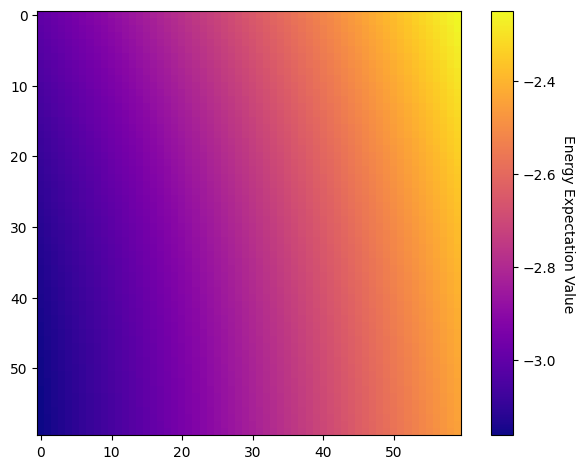

In [15]:
t1 = 60
t2 = 60
Parameter_Space = np.zeros(shape=(t1,t2))
Ground_State = [100,0,0]
H = {'X':3,'Y':-2,'Z':1}
Hk = list( H.keys() )
#--------------------------------------------------
for i in np.arange( t1 ):
  theta = m.pi/2+ (m.pi/10)*(i/t1)
  for j in np.arange( t2 ):
    phi = m.pi+ (m.pi/10)*(j/t2)
    EV = 0
    for k in np.arange(len(Hk)):
      q = QuantumRegister( 1, name='q' )
      qc= QuantumCircuit( q, name='qc')
      Single_Qubit_Ansatz( qc, q[0], [theta, phi] )
      sv0 = execute( qc, S_simulator, shots=1 ).result().get_statevector()
      if( Hk[k] == 'X' ):
        qc.x(q[0])
      if( Hk[k] == 'Y' ):
        qc.y(q[0])
      if( Hk[k] == 'Z' ):
        qc.z(q[0])
      sv = execute( qc, S_simulator, shots=1 ).result().get_statevector()
      ev = 0
      for k2 in np.arange(len(sv)):
        ev = ev + (np.conj(sv[int(k2)])*sv0[int(k2)]).real
      EV = EV + H[Hk[k]] * ev
    Parameter_Space[i,j] = EV
    if( Parameter_Space[i,j] < Ground_State[0] ):
      Ground_State[0] = Parameter_Space[i,j]
      Ground_State[1] = theta
      Ground_State[2] = phi
#==================================================
fig, ax = plt.subplots()
show_text = False
show_ticks = False
Heatmap(Parameter_Space, show_text, show_ticks, ax, "plasma", "Energy Expectation Value")
fig.tight_layout()
plt.show()

As we can see, both energy landscapes show the same general shape, but the one produced from using the quantum system's wavefunction is much
smoother. Conversely, **the plot produced from using simulated measurements shows slight deviations throughout, resulting in values at each location that are
either slightly bigger or smaller than the true value (those obtained via the wavefunction method)**.

So to answer our question from earlier: why did our VQE optimizer fail to find the global minimum on what appeared to be a pretty straightforward energy landscape, we needn't look at further than the imperfections produced from the measurement technique. Inside our VQE Gradient Descent optimizer, we approximate the slope at any given point by using two nearby points in both directions ε distance away. However,as
shown by the "bumpy" energy landscape above, computing these slopes using measurements can lead to inaccurate approximations, sometimes even the
complete wrong direction! For example, consider the diagrams shown below and their resulting approximations to the slope:

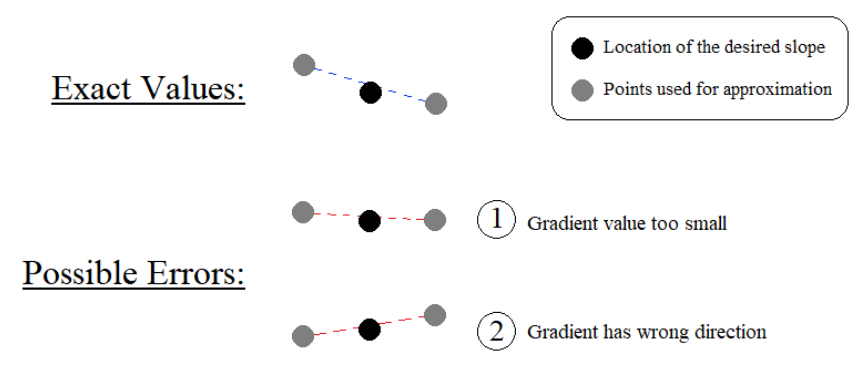

In both of the error configurations shown above, the slopes obtained using nearest neighbor points will result in early termination of our algorithm:
1.  If the two neighboring points happen to be too close in value, the resulting gradient obtained will be smaller than our δ threshold for continuing. Consequently, the algorithm will interpret the small slope to mean that we've reached a minima, terminating prematurely.
2.  If the values of the two neighboring points happen to result in a gradient that is in the opposite direction of the true slope, then the next step will be in the complete wrong direction! As a result, when we calculate the next energy expectation value, we've essentially climbed "uphill", resulting in a termination of
our algorithm.

While Gradient Descent is certainly a powerful algorithm for finding minima in a parameter space, it is not the only technique in town. Remember that our goal
is to pair the VQE Algorithm with the best suited classical optimizer to search through a given energy landscape. Therefore, the examples above serve to show that Gradient Descent probably shouldn't be our first choice. 

Alternatively, in the upcoming session we will be implementing a different optimization scheme: the Nelder-Mead method, which will be able to find the minima despite the fluctuations in the parameter space resulting from measurements

But before moving on to this second optimization technique, let's confirm that our Gradient Descent implementation would have worked if not for these fluctuations:

In [16]:
def VQE_EV(params, Ansatz, H, EV_type, **kwargs):
  '''
  Input:
  params (array)
  Ansatz( Single or Two Qubit Ansatz function)
  H (Dictionary)
  EV_type (string)
  Keyword Arguments:
  shots (integer) - Dictates the number of measurements to use per computation
  Computes and returns the expectation value for a given Hamiltonian and set of theta / phi values
  '''
  Shots = 10000
  if 'shots' in kwargs:
    Shots = int( kwargs['shots'] )
  Hk = list( H.keys() )
  H_EV = 0
  for k in np.arange( len(Hk) ):
    L = list( Hk[k] )
    q = QuantumRegister(len(L))
    c = ClassicalRegister(len(L))
    qc= QuantumCircuit(q,c)
    Ansatz( qc, q, params )
    sv0 = execute( qc, S_simulator, shots=1 ).result().get_statevector()
    if( EV_type == 'wavefunction' ):
      for l in np.arange( len(L) ):
        if( L[l] == 'X' ):
          qc.x( q[int(l)] )
        if( L[l] == 'Y' ):
          qc.y( q[int(l)] )
        if( L[l] == 'Z' ):
          qc.z( q[int(l)] )
      sv = execute( qc, S_simulator, shots=1 ).result().get_statevector()
      H_ev = 0
      for l2 in np.arange(len(sv)):
        H_ev = H_ev + (np.conj(sv[int(l2)])*sv0[int(l2)]).real
      H_EV = H_EV + H[Hk[k]] * H_ev
    elif( EV_type == 'measure' ):
      for l in np.arange( len(L) ):
        if( L[l] == 'X' ):
          qc.ry(-m.pi/2,q[int(l)])
        if( L[l] == 'Y' ):
          qc.rx( m.pi/2,q[int(l)])
      qc.measure( q,c )
      job = execute(qc,M_simulator,shots=10000)
      result = job.result()
      M = result.get_counts(qc)
      #M = Measurement( qc, shots=Shots, print_M=False, return_M=True )
      Mk = list( M.keys() )
      H_ev = 0
      for m1 in np.arange(len(Mk)):
        MS = list( Mk[m1] )
        e = 1
        for m2 in np.arange(len(MS)):
          if( MS[m2] == '1' ):
            e = e*(-1)
        H_ev = H_ev + e * M[Mk[m1]]
      H_EV = H_EV + H[Hk[k]]*H_ev/Shots
  return H_EV

In [17]:
 H = {'X':3,'Y':-2,'Z':1}
Hk = list( H.keys() )
Ground_State = [100,0,0]
epsilon = 0.05
step_size = 0.01
delta = 0.00005
M_bool = False
#-----------------------
EV = 100
EV_old = 1000
terminate=False
EV_type = 'wavefunction'
#========================================================
theta = m.pi*random.random()
phi = 2*m.pi*random.random()
iters = 0
while( (abs( EV - EV_old ) > delta) and (terminate==False) ):
  EV_old = EV
  EV = VQE_EV([theta,phi],Single_Qubit_Ansatz,H,EV_type)
  if( (iters/10.0)==m.ceil(iters/10.0) ):
    print('Iterations: ',iters,'EV:',round(EV,5),'\u03B8 = ',round(theta,5),'\u03C6 = ',round(phi,5))
  if( EV > EV_old ):
    terminate = True
  else:
    if( EV < Ground_State[0] ):
      Ground_State[0] = EV
      Ground_State[1] = theta
      Ground_State[2] = phi
    theta_old = theta
    phi_old = phi
    theta,phi = VQE_Gradient_Descent(qc,q,H,Single_Qubit_Ansatz,theta,phi,epsilon,step_size,measure=M_bool)
    iters = iters + 1
if( (abs( EV - EV_old ) < delta) or (terminate==True) ):
  print('\n_____ Gradient Descent Complete _____\n')
  print('Iterations: ',iters,'EV:',round(Ground_State[0],5),'\u03B8 = ',round(Ground_State[1],5),'\u03C6 = ',round(Ground_State[2],5))

Iterations:  0 EV: 1.5972 θ =  2.27843 φ =  0.02104
Iterations:  10 EV: 0.93542 θ =  2.55924 φ =  -0.12091
Iterations:  20 EV: 0.06179 θ =  2.8361 φ =  -0.22952
Iterations:  30 EV: -0.81783 θ =  3.08895 φ =  -0.2799
Iterations:  40 EV: -1.57925 θ =  3.3163 φ =  -0.26584
Iterations:  50 EV: -2.17242 θ =  3.52454 φ =  -0.19562
Iterations:  60 EV: -2.55826 θ =  3.71649 φ =  -0.08641
Iterations:  70 EV: -2.71549 θ =  3.88818 φ =  0.03999

_____ Gradient Descent Complete _____

Iterations:  74 EV: -2.72163 θ =  3.93472 φ =  0.07807


The example above represents what we could have originally expected from our Gradient Descent technique, but it critically relies on using wavefunctions to
compute gradients (which is effectively cheating). Although the code was unable to find the true global minimum, instead getting stuck in a local minima, we can still see that the optimization technique can work. Thus we can conclude that it is indeed the approximations from taking measurements which causes 
the Gradient Descent technique to ultimately be unusable.

# **Nelder-Mead Optimization Method**
***

The basic premise for the Nelder-Mead technique, using a 2-parameter space as our example, is to use a triangle of points to iteratively step towards the
minima of the space. At each step in the algorithm we compute the energy expectation value of the three vertices, and use these values to determine the next
step. In essence, the goal of each step is to replace the worst valued vertex of our triangle with a new one closer to the minima. Below is rough outline of the
technique, further explaining some of the possible steps one can take with each iteration:

1. 
 Pick a starting location somewhere in the space and choose
 N +1
 relatively grouped points, where
 N
 is the dimensionality of the parameter space. The geometric shape created from these points is known as our simplex, which is essentially a triangle extended to any dimensional space. For our N=2 case, our simplex is exactly a triangle. Using the N+1 points, we evaluate $F(x_n)$ at each vertex of the simplex and order them accordingly from highest to lowest. For our VQE Algorithm,
these are the energy expectation values we compute through repeat measurements.

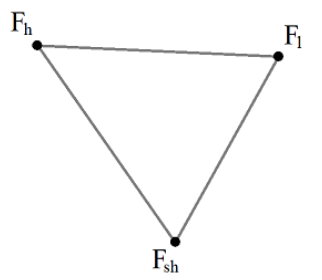

2. Next, we drop the highest value in our simplex, $F_h$ , and calculate the centroid from the remaining vertices. For our two dimensional case, this means
 calculating the point directly between $F_1$ and $F_{sh}$. Once this point is obtained, we evaluate it and obtain $F_{c}$

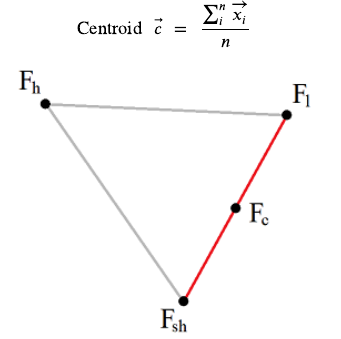

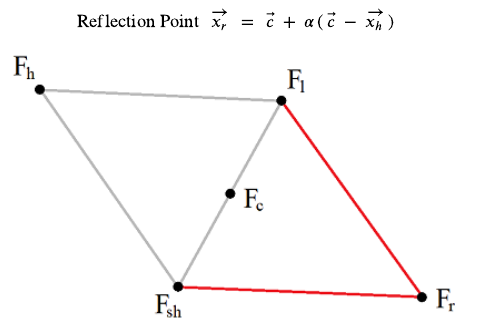

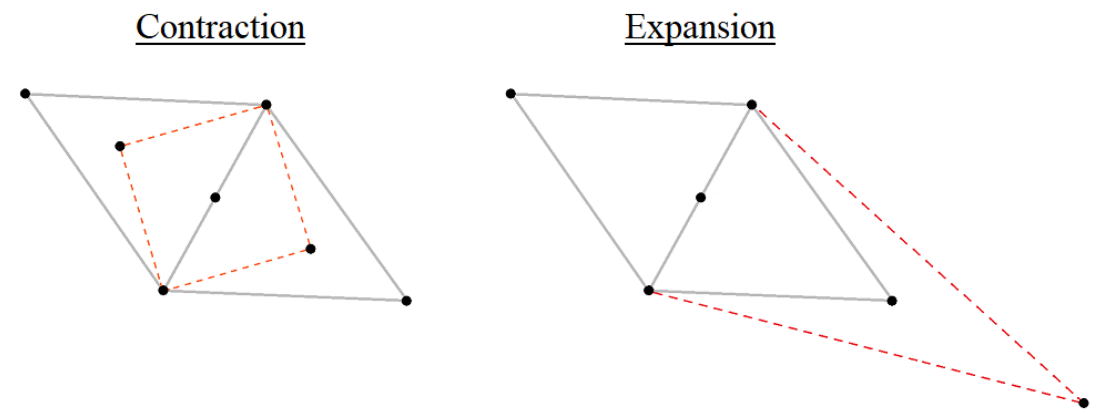

To summarize, the Nelder-Mead optimization technique converges on the minima of our parameter space by iteratively moving through simplexes. At each
step we discard the vertex corresponding to the worst value, and replace it with a new vertex that brings us closer to the final minima. And, to return to the
original motivation for introducing this optimization technique, hopefully the diagrams shown above illustrate that the separation between vertices is
sufficiently large enough that we will avoid the issue we ran into with Gradient Descent. Even with slight fluctuations at each location resulting from taking
measurements, our algorithm will still be able to converge on the minima of our parameter space.

[Nelder-Mead Optimization Algorithm Animation](https://www.youtube.com/watch?v=j2gcuRVbwR0&ab_channel=MilesChen)

In [18]:
def Calculate_MinMax(V, C_type):
  '''
  Input:
  V (vert)
  C_type (string)
  Returns the smallest or biggest value / index for the smallest value in a list
  '''
  if( C_type == 'min' ):
    lowest = [V[0],0]
    for i in np.arange(1,len(V)):
      if( V[i] < lowest[0] ):
        lowest[0] = V[i]
        lowest[1] = int(i)
    return lowest
  if( C_type == 'max' ):
    highest = [V[0],0]
    for i in np.arange(1,len(V)):
      if( V[i] > highest[0] ):
        highest[0] = V[i]
        highest[1] = int(i)
    return highest


def Compute_Centroid(V):
  '''
  Input:
  V (array)
  Computes and returns the centroid from a given list of values
  '''
  points = len( V )
  dim = len( V[0] )
  Cent = []
  for d in np.arange( dim ):
    avg = 0
    for a in np.arange( points ):
      avg = avg + V[a][d]/points
    Cent.append( avg )
  return Cent


def Reflection_Point(P1, P2, alpha):
  '''
  Input:
  P1 (array)
  P2 (array)
  alpha (float)
  Computes a reflection point from P1 around point P2 by an amount alpha
  '''
  P = []
  for p in np.arange( len(P1) ):
    D = P2[p] - P1[p]
    P.append( P1[p]+alpha*D )
  return P

In [19]:
def Nelder_Mead(H, Ansatz, Vert, Val, EV_type):
  '''
  Input:
  H (Dictionary)
  Ansatz( Single or Two Qubit Ansatz function)
  Vert (array)
  Val (array)
  Computes and appends values for the next step in the Nelder_Mead Optimization Algorithm
  '''
  alpha = 2.0
  gamma = 2.0
  rho= 0.5
  sigma = 0.5
  add_reflect = False
  add_expand = False
  add_contract = False
  shrink = False
  add_bool = False
  #----------------------------------------
  hi = Calculate_MinMax( Val,'max' )
  Vert2 = []
  Val2 = []
  for i in np.arange(len(Val)):
    if( int(i) != hi[1] ):
      Vert2.append( Vert[i] )
      Val2.append( Val[i] )
  Center_P = Compute_Centroid( Vert2 )
  Reflect_P = Reflection_Point(Vert[hi[1]],Center_P,alpha)
  Reflect_V = VQE_EV(Reflect_P,Ansatz,H,EV_type)
  #-------------------------------------------------
  # Determine if: Reflect / Expand / Contract / Shrink
  hi2 = Calculate_MinMax( Val2,'max' )
  lo2 = Calculate_MinMax( Val2,'min' )
  if( hi2[0] > Reflect_V >= lo2[0] ):
    add_reflect = True
  elif( Reflect_V < lo2[0] ):
    Expand_P = Reflection_Point(Center_P,Reflect_P,gamma)
    Expand_V = VQE_EV(Expand_P,Ansatz,H,EV_type)
    if( Expand_V < Reflect_V ):
      add_expand = True
    else:
      add_reflect = True
  elif( Reflect_V > hi2[0] ):
    if( Reflect_V < hi[0] ):
      Contract_P = Reflection_Point(Center_P,Reflect_P,rho)
      Contract_V = VQE_EV(Contract_P,Ansatz,H,EV_type)
      if( Contract_V < Reflect_V ):
        add_contract = True
      else:
        shrink = True
    else:
      Contract_P = Reflection_Point(Center_P,Vert[hi[1]],rho)
      Contract_V = VQE_EV(Contract_P,Ansatz,H,EV_type)
      if( Contract_V < Val[hi[1]] ):
        add_contract = True
      else:
        shrink = True
  #-------------------------------------------------
  # Apply: Reflect / Expand / Contract / Shrink
  if( add_reflect == True ):
    new_P = Reflect_P
    new_V = Reflect_V
    add_bool = True
  elif( add_expand == True ):
    new_P = Expand_P
    new_V = Expand_V
    add_bool = True
  elif( add_contract == True ):
    new_P = Contract_P
    new_V = Contract_V
    add_bool = True
  if( add_bool ):
    del Vert[hi[1]]
    del Val[hi[1]]
    Vert.append( new_P )
    Val.append( new_V )
  if( shrink ):
    Vert3 = []
    Val3 = []
    lo = Calculate_MinMax( Val,'min' )
    Vert3.append( Vert[lo[1]] )
    Val3.append( Val[lo[1]] )
    for j in np.arange( len(Val) ):
      if( int(j) != lo[1] ):
        Shrink_P = Reflection_Point(Vert[lo[1]],Vert[j],sigma)
        Vert3.append( Shrink_P )
        Val3.append( VQE_EV(Shrink_P,Ansatz,H,EV_type) )
    for j2 in np.arange( len(Val) ):
      del Vert[0]
      del Val[0]
      Vert.append( Vert3[j2] )
      Val.append( Val3[j2] )

In [20]:
H = {'X':3,'Y':-2,'Z':1}
EV_type = 'measure'
theta = random.random()*m.pi
phi = random.random()*2*m.pi
delta = 0.001
#------------------------------
Vertices = []
Values = []
radius = 0.35
R = random.random()*(2*m.pi/3)
for rr in np.arange(3):
  Vertices.append( [theta+radius*m.cos(R+(rr*2*m.pi/3)),phi+radius*m.sin(R+(rr*2*m.pi/3))] )
for v in np.arange(len(Vertices)):
  Values.append( VQE_EV(Vertices[v],Single_Qubit_Ansatz,H,EV_type) )
#------------------------------
terminate = False
iters = 0
terminate_count = 0
terminate_limit = 6
while( (terminate==False) and (iters < 100) ):
  iters = iters + 1
  low = Calculate_MinMax( Values,'min' )
  Nelder_Mead(H, Single_Qubit_Ansatz, Vertices, Values, EV_type)
  new_low = Calculate_MinMax( Values,'min' )
  if( abs( new_low[0] - low[0] ) < delta ):
    terminate_count = terminate_count + 1
  else:
    terminate_count = 0
  if( terminate_count >= terminate_limit ):
    terminate = True
    print('\n_____ Nelder-Mead Complete _____\n')
    print('Iteration: ',iters,'Lowest EV: ',round(low[0],6),'\u03B8 = ',round(Vertices[low[1]][0],4),'\u03C6 = ',round(Vertices[low[1]][1],4))
  if( ( (iters==1) or (m.ceil(iters/5))==m.floor(iters/5) ) and (terminate==False) ):
    print('Iteration: ',iters,'Lowest EV: ',round(low[0],6),'\u03B8 = ',round(Vertices[low[1]][0],4),'\u03C6 = ',round(Vertices[low[1]][1],4))

Iteration:  1 Lowest EV:  -2.0568 θ =  0.9379 φ =  2.8702
Iteration:  5 Lowest EV:  -3.5892 θ =  1.9425 φ =  2.1915
Iteration:  10 Lowest EV:  -3.7246 θ =  1.8914 φ =  2.6319
Iteration:  15 Lowest EV:  -3.7926 θ =  1.8565 φ =  2.5376
Iteration:  20 Lowest EV:  -3.8018 θ =  1.864 φ =  2.5268

_____ Nelder-Mead Complete _____

Iteration:  23 Lowest EV:  -3.8018 θ =  1.864 φ =  2.5268


As promised, our code implementation of the Nelder-Mead optimization technique above results in a converging search towards the global minimum of our
parameter space. And most importantly, it works despite the fluctuations resulting from taking measurements. I encourage you to run the cell of code a few
times to get a feel for the converging speed / success rate of this new technique. What you should find is that while the search isn't a guaranteed 100%
success, it is still far more reliable than the Gradient Descent technique from earlier, even when using wavefunctions.

# **Spanning Higher Dimensional Hilbert Spaces**
***

At this point in the lesson, we have covered all of the key topics that make up the Variational Quantum Eigensolver Algorithm. However, all of our examples
up until this point have been for single qubit systems, so as our final topic, we will now discuss how to apply the VQE Algorithm to problems requiring more
qubits.

In order to appreciate the difficulty of scaling the VQE technique to larger problems, we must return back to our discussion from earlier about the Variational
Principle and the role of ansatz states $|ψ(θ)⟩$. Remember that the most important thing we require from our ansatz state is that it spans the complete Hilbert
space, thereby giving our algorithm the necessary platform to converge on the ground state energy. For the case of a single qubit, we showed that reaching
all possible states in the system is achievable through two parameters, corresponding to rotations on the Bloch Sphere. Extending this line of reasoning to
two qubits then, a natural first guess is to suspect that we can similarly span the complete 2-qubit Hilbert space using four parameters. However, this is
unfortunately not the case. No amount of single qubit rotation gates is enough to span the full 2-qubit Hilbert Space. To illustrate this, consider the math exercise below:

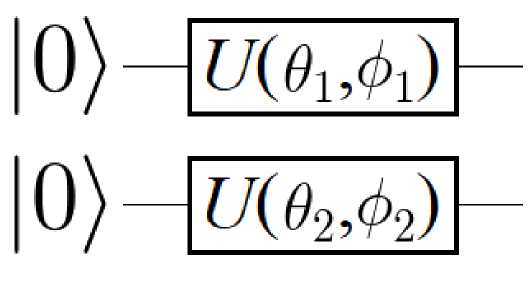

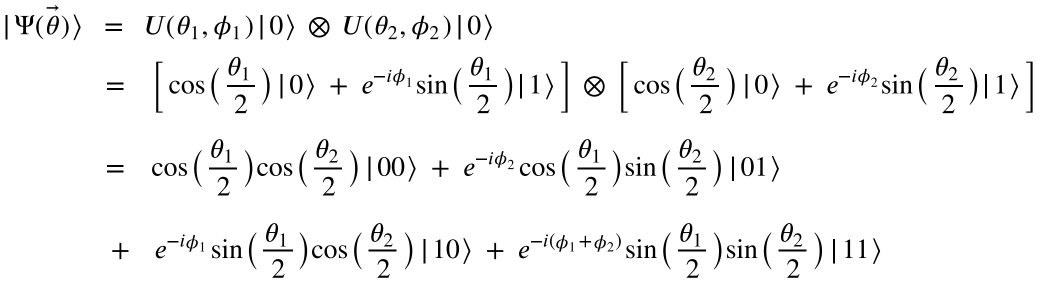

At first glance, the state above may look general enough to span all possible 2-qubit states. However, because of the way in which we've created this state
through only single qubit operations, this state can only cover all possible $non-entangled$ quantum states. For example, suppose the ground state to a
particular problem was:

$$|ψ_{0}⟩ = \frac{1}{\sqrt{2}}(|00⟩+ |11⟩)  $$ 

If we tried to reach this state via our 4-parameters shown above, we run into the following issues:

$$condition 1: cos(\frac{θ_{1}}{2})sin(\frac{θ_{2}}{2}) = 0 $$

$$condition 2: sin(\frac{θ_{1}}{2})cos(\frac{θ_{2}}{2}) = 0 $$


In order to make sure that our ansatz state doesn't contain |01⟩ or |10⟩, we run into the contradictory conditions shown above. As an example, let's
suppose we pick $θ_{1} = π$ and $θ_{2} = π$ , which guarantees that both equations shown above will equal 0. However, when we plug in these choices for $θ_{1}$ and $θ_{2}$,our resulting ansatz state becomes:

$$e^{i(ϕ_{1} + ϕ_{2})}|11⟩$$

The conditions shown above are meant to illustrate that there is no combination of parameters which will yield the desired ansatz state. Physically, this is because the state $|ψ_{0}⟩$ contains entanglement, which means that we need to include at least one additional 2-qubit gate in our ansatz preparation circuit:

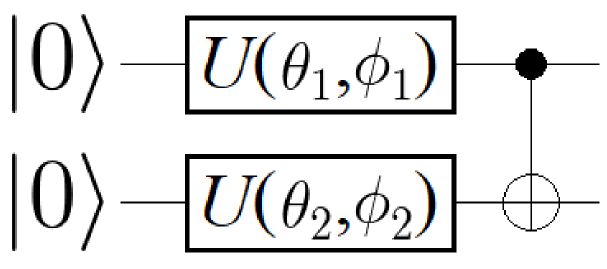

By adding a CNOT gate into our ansatz circuit, we are now able to reach states within the 2-qubit Hilbert space which were previously unavailable to us. For
example, by selecting the parameters:$θ_{1} = \frac{π}{2} $, $θ_{2}=0$, $ϕ_{1} = \frac{π}{2}$, we are now able to reach our target state above. However, the inclusion of this
additional CNOT gate still isn't enough to reach our goal of spanning the complete 2-qubit Hilbert space. To do this, we will need to expand our circuit further
to include more parameters and CNOT gates:
 

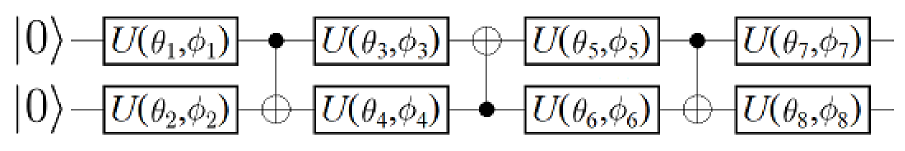

The circuit shown above represents a universal 2-qubit ansatz state, able to span the full 2-qubit Hilbert space. Proving that the circuit above is truly universal
is a bit beyond the scope of this lesson. For the purpose of our VQE Algorithm, the
circuit shown above will serve as our ansatz preparation circuit, leaving us with a total of 16 free parameters. Jumping from 2 to 16 parameters by introducing
a second qubit is quite a leap in our parameter space, and in truth it speaks volumes about the complexity of working with quantum states. It's subtle to
appreciate at first, but these enormous Hilbert spaces serve as a demonstration of the potential computing power that quantum computers can achieve with
minimal qubits.

## **Final Example: 2-Qubit VQE**
***

When implementing the
 16
 variable quantum circuit shown above, spanning the complete 2
-qubit Hilbert space, we must be mindful that at the end of the day that VQE is ultimately a classical optimizer driven algorithm. At a certain point, we need to consider whether carrying extra free parameters is worth the additional computing costs, or if we should simply work with a smaller parameter space. In the coming final example, we will be working with an ansatz state
that only contains the gates shown above up to the second CNOT gate (not including the second CNOT though), leaving us with a total of free parameters. Although reducing our parameter space by a factor of 2 may seem like a lot, it actually saves our algorithm in terms of both speed and accuracy. It should
make sense that optimizing 8 versus 16 parameters is much quicker, but also consider the difference in complexity between the two parameter spaces. While
it's true the full ansatz circuit can reach a larger portion of the 2-qubit Hilbert space, the tradeoff is that it creates more potential for our classical optimizer to
get stuck in local minima. As a result, using the full 16 parameter ansatz circuit can sometimes be $worse$
at finding the true ground state energy to our
problem, or a very close approximation.

Below is the code implementation of our Nelder-Mead based VQE algorithm for the following Hamiltonian:

$$H = 3XY − 2ZZ$$

which has a ground state energy of −5, corresponding to the state $\frac{1}{\sqrt{2}}(i|00⟩+ |11⟩)$



In [21]:
def Two_Qubit_Ansatz(qc, q, params):
  '''
  Input:
  qc (QuantumCircuit)
  q (QuantumRegister)
  params (array)
  Applies the neccessary rotation and CNOT gates for a two qubit ansatz state
  '''
  Single_Qubit_Ansatz( qc, q[0], [params[0], params[1]] )
  Single_Qubit_Ansatz( qc, q[1], [params[2], params[3]] )
  qc.cx( q[0], q[1] )
  Single_Qubit_Ansatz( qc, q[0], [params[4], params[5]] )
  Single_Qubit_Ansatz( qc, q[1], [params[6], params[7]] )

In [22]:
H = {'XY':3,'ZZ':-2}
EV_type = 'measure'
P = []
for p in np.arange(4):
  P.append( random.random()*m.pi )
  P.append( random.random()*2*m.pi )
delta = 0.001
#------------------------------
Vertices = []
Values = []
for v1 in np.arange(len(P)):
  V = []
  for v2 in np.arange(len(P)):
    R = round((0.4+random.random()*0.8)*(-1)**( round(random.random())),5)
    V.append( P[v2]+R )
  Vertices.append( V )
  Values.append( VQE_EV(V,Two_Qubit_Ansatz,H,EV_type) )
#------------------------------
terminate = False
iters = 0
terminate_count = 0
terminate_limit = 10
while( (terminate==False) and (iters < 100) ):
  iters = iters + 1
  low = Calculate_MinMax( Values,'min' )
  Nelder_Mead(H, Two_Qubit_Ansatz, Vertices, Values, EV_type)
  new_low = Calculate_MinMax( Values,'min' )
  if( abs( new_low[0] - low[0] ) < delta ):
    terminate_count = terminate_count + 1
  else:
    terminate_count = 0
  if( terminate_count >= terminate_limit ):
    terminate = True
    print('\n_____ Nelder-Mead Complete _____\n')
    print(' --------------------- \n Iteration: ',iters,'Lowest EV: ',round( low[0],6 ))
  if( ( (iters==1) or (m.ceil(iters/10))==m.floor(iters/10) ) and (terminate==False) ):
    print('Iteration: ',iters,'Lowest EV: ',round( low[0],6 ))

Iteration:  1 Lowest EV:  -2.1762
Iteration:  10 Lowest EV:  -2.1762
Iteration:  20 Lowest EV:  -3.3016
Iteration:  30 Lowest EV:  -4.7014
Iteration:  40 Lowest EV:  -4.8336
Iteration:  50 Lowest EV:  -4.891
Iteration:  60 Lowest EV:  -4.9748
Iteration:  70 Lowest EV:  -4.9876
Iteration:  80 Lowest EV:  -4.993
Iteration:  90 Lowest EV:  -4.9968

_____ Nelder-Mead Complete _____

 --------------------- 
 Iteration:  94 Lowest EV:  -4.9968


As illustrated above, 8 parameters is sufficient for coming very close to the true ground state energy. And if you're curious as to how the algorithm would have
performed with the full 16 parameter ansatz circuit, I encourage you to try for yourself by replacing the **Two_Qubit_Ansatz** function with the full circuit
shown earlier. What you will likely find is that the Nelder-Mead search struggles to find the global minimum, oftentimes getting stuck in local minima or terminating early due to slow progression.

References:

1. https://qiskit.org/textbook/ch-applications/vqe-molecules.html 
2. https://qiskit.org/documentation/stubs/qiskit.algorithms.VQE.html 
3. https://qiskit.org/documentation/nature/ 
4. https://qiskit.org/documentation/nature/tutorials/index.html 
5. https://qiskit-community.github.io/qiskit-nature/tutorials/03_ground_state_solvers.html
